In [1]:
import pandas as pd
import numpy as np

# 可視化用のライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import neologdn
import MeCab

import re

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
# # プログレスバーのラベル設定
tqdm_notebook.pandas(desc="progress: ")

In [2]:
df = pd.read_csv('all_text_wakatigaki.csv',encoding='utf-8')
df.head()

,surface,yomi,original,type,katsuyoukei,katsuyougata,内容
0,neologd,ネオログディー,NEologd,名詞-固有名詞-一般,NaN,NaN,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...
1,_,_,_,記号-一般,NaN,NaN,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...
2,tagger,タガー,tagger,名詞-固有名詞-一般,NaN,NaN,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...
3,.,.,.,記号-一般,NaN,NaN,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...
4,parse,パース,Parse,名詞-固有名詞-一般,NaN,NaN,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...


## TF値算出

In [3]:
# 単語名は同一でも品詞名が違う組み合わせがあるので単語名と品詞名を組み合わせた要素を格納した新規カラムを作成する
df['original_type'] = df['original'] + '_' + df['type']
df.head()

,surface,yomi,original,type,katsuyoukei,katsuyougata,内容,original_type
0,neologd,ネオログディー,NEologd,名詞-固有名詞-一般,NaN,NaN,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般
1,_,_,_,記号-一般,NaN,NaN,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,__記号-一般
2,tagger,タガー,tagger,名詞-固有名詞-一般,NaN,NaN,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,tagger_名詞-固有名詞-一般
3,.,.,.,記号-一般,NaN,NaN,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般
4,parse,パース,Parse,名詞-固有名詞-一般,NaN,NaN,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,Parse_名詞-固有名詞-一般


In [4]:
# 必要カラムのみ抽出
df = df[['yomi', '内容', 'original_type']]
df.head()

,yomi,内容,original_type
0,ネオログディー,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般
1,_,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,__記号-一般
2,タガー,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,tagger_名詞-固有名詞-一般
3,.,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般
4,パース,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,Parse_名詞-固有名詞-一般


In [5]:
# [内容]×[original_type]の組み合わせの数をカウント
contents_word_cnt_df = df.groupby(['内容', 'original_type']).count().reset_index()
contents_word_cnt_df = contents_word_cnt_df.rename(columns={'yomi':'count'})
contents_word_cnt_df.head()

,内容,original_type,count
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,(_記号-一般,1
1,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,)_記号-一般,1
2,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般,1
3,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,1_名詞-数,1
4,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般,1


In [6]:
# 文書毎に含まれる単語数をカウント

# [内容]カラムをグループ化しカウント　
# reset_index関数を使い[内容]カラムをindex部分からデータ列部分に戻す
per_sentence_word_cnt = df.groupby('内容')['original_type'].count().reset_index()
per_sentence_word_cnt = per_sentence_word_cnt.rename(columns={'original_type':'word_count'})
per_sentence_word_cnt.head()

,内容,word_count
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,26
1,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,30
2,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,33
3,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,41


In [7]:
# [count]と[word_count]を [内容]で紐づけ
contents_merge_df = pd.merge(contents_word_cnt_df, per_sentence_word_cnt, on='内容', how='inner')
contents_merge_df.head(27)

,内容,original_type,count,word_count
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,(_記号-一般,1,26
1,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,)_記号-一般,1,26
2,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般,1,26
3,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,1_名詞-数,1,26
4,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般,1,26
5,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,Parse_名詞-固有名詞-一般,1,26
6,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,__記号-一般,1,26
7,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,tagger_名詞-固有名詞-一般,1,26
8,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,text_名詞-固有名詞-一般,1,26
9,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,、_記号-読点,1,26


In [8]:
# 欠損値があるか確認
contents_merge_df.isnull().any()

内容               False
original_type    False
count            False
word_count       False
dtype: bool

In [9]:
# tf値算出に必要なカラム（分子と分母の値があるカラム）のみ抽出
tmp_tf_df = contents_merge_df[['count', 'word_count']]
tmp_tf_df.head()

,count,word_count
0,1,26
1,1,26
2,1,26
3,1,26
4,1,26


In [10]:
# tf値算出
# axis=1をつけないと"occurred at index count"とエラーが発生する（デフォルトがaxis=0のため）
contents_merge_df['tf'] = tmp_tf_df.progress_apply(lambda x: x['count'] / x['word_count'], axis=1)

In [11]:
# tf値が紐づいたか確認
contents_merge_df.head()

,内容,original_type,count,word_count,tf
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,(_記号-一般,1,26,0.038462
1,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,)_記号-一般,1,26,0.038462
2,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般,1,26,0.038462
3,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,1_名詞-数,1,26,0.038462
4,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般,1,26,0.038462


## IDF値算出

In [12]:
# idfの分子（全文書数）
len(contents_word_cnt_df['内容'].value_counts())

4

In [13]:
# idfの分母「各単語が出現する文書の数」の算出
# [original_type]×[内容]のクロス集計表を作成

idf_pivot_df = pd.pivot_table(contents_merge_df, index='original_type', columns='内容', aggfunc=len, values='count')
#tf_pivot_df = pd.pivot_table(contents_merge_df, index='original_type', columns='内容', values='count')#aggfuncを指定しないと[count]カラムの数字が入る
idf_pivot_df

内容,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して表示される,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、リスト型にする,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid_textは文字列型ではなくリスト型のためsplit関数を使用できない
original_type,,,,
')_記号-一般,NaN,NaN,NaN,1.0
('\_記号-一般,NaN,NaN,NaN,1.0
()_名詞-固有名詞-一般,NaN,1.0,NaN,NaN
(_記号-一般,1.0,NaN,NaN,NaN
)_記号-一般,1.0,NaN,NaN,NaN
._記号-一般,1.0,NaN,NaN,NaN
1_名詞-数,1.0,NaN,NaN,NaN
1つ_名詞-一般,NaN,1.0,NaN,NaN
NEologd_名詞-固有名詞-一般,1.0,NaN,NaN,NaN


In [14]:
idf_pivot_df1 = idf_pivot_df > 0
idf_pivot_df1# 1以上ならTrue、1未満ならFalse

内容,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して表示される,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、リスト型にする,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid_textは文字列型ではなくリスト型のためsplit関数を使用できない
original_type,,,,
')_記号-一般,False,False,False,True
('\_記号-一般,False,False,False,True
()_名詞-固有名詞-一般,False,True,False,False
(_記号-一般,True,False,False,False
)_記号-一般,True,False,False,False
._記号-一般,True,False,False,False
1_名詞-数,True,False,False,False
1つ_名詞-一般,False,True,False,False
NEologd_名詞-固有名詞-一般,True,False,False,False


In [15]:
# True＝１なのでTureの数を行毎に合計
# それを格納するカラム[word_include_text_count]を追加
# この値がidfの分母となる
idf_pivot_df1['word_include_text_count'] = idf_pivot_df1.sum(axis=1)
idf_pivot_df1

内容,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して表示される,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、リスト型にする,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid_textは文字列型ではなくリスト型のためsplit関数を使用できない,word_include_text_count
original_type,,,,,
')_記号-一般,False,False,False,True,1
('\_記号-一般,False,False,False,True,1
()_名詞-固有名詞-一般,False,True,False,False,1
(_記号-一般,True,False,False,False,1
)_記号-一般,True,False,False,False,1
._記号-一般,True,False,False,False,1
1_名詞-数,True,False,False,False,1
1つ_名詞-一般,False,True,False,False,1
NEologd_名詞-固有名詞-一般,True,False,False,False,1


In [16]:
# 必要なカラム(新規作成カラム、マージするときのキーのカラム）のみ抽出
idf_pivot_df2 = idf_pivot_df1.reset_index()[['original_type', 'word_include_text_count']]
idf_pivot_df2

内容,original_type,word_include_text_count
0,')_記号-一般,1
1,('\_記号-一般,1
2,()_名詞-固有名詞-一般,1
3,(_記号-一般,1
4,)_記号-一般,1
5,._記号-一般,1
6,1_名詞-数,1
7,1つ_名詞-一般,1
8,NEologd_名詞-固有名詞-一般,1
9,Parse_名詞-固有名詞-一般,2


In [17]:
# 新規に作成した「各単語が出現する文書の数」カラムを[original_type]をキーにして連結
idf_merge_df = pd.merge(contents_merge_df, idf_pivot_df2, on='original_type', how='inner')
idf_merge_df

,内容,original_type,count,word_count,tf,word_include_text_count
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,(_記号-一般,1,26,0.038462,1
1,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,)_記号-一般,1,26,0.038462,1
2,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般,1,26,0.038462,1
3,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,1_名詞-数,1,26,0.038462,1
4,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般,1,26,0.038462,1
5,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,Parse_名詞-固有名詞-一般,1,26,0.038462,2
6,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,Parse_名詞-固有名詞-一般,1,30,0.033333,2
7,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,__記号-一般,1,26,0.038462,2
8,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,__記号-一般,1,41,0.024390,2
9,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,tagger_名詞-固有名詞-一般,1,26,0.038462,1


In [18]:
idf_merge_df.isnull().any()

内容                         False
original_type              False
count                      False
word_count                 False
tf                         False
word_include_text_count    False
dtype: bool

In [19]:
# dfの分子（全文書数）を格納する新規カラムを追加
idf_merge_df['all_text_count'] = len(contents_word_cnt_df['内容'].value_counts())
idf_merge_df

,内容,original_type,count,word_count,tf,word_include_text_count,all_text_count
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,(_記号-一般,1,26,0.038462,1,4
1,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,)_記号-一般,1,26,0.038462,1,4
2,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般,1,26,0.038462,1,4
3,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,1_名詞-数,1,26,0.038462,1,4
4,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般,1,26,0.038462,1,4
5,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,Parse_名詞-固有名詞-一般,1,26,0.038462,2,4
6,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,Parse_名詞-固有名詞-一般,1,30,0.033333,2,4
7,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,__記号-一般,1,26,0.038462,2,4
8,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,__記号-一般,1,41,0.024390,2,4
9,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,tagger_名詞-固有名詞-一般,1,26,0.038462,1,4


In [20]:
# idfを算出
# データフレーム型にapply関数を使う際には、axis=1を忘れないように注意
import math
idf_merge_df['idf'] = idf_merge_df.progress_apply(lambda x: math.log(x['all_text_count'] / x['word_include_text_count']) + 1 , axis=1)

In [21]:
idf_merge_df

,内容,original_type,count,word_count,tf,word_include_text_count,all_text_count,idf
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,(_記号-一般,1,26,0.038462,1,4,2.386294
1,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,)_記号-一般,1,26,0.038462,1,4,2.386294
2,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般,1,26,0.038462,1,4,2.386294
3,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,1_名詞-数,1,26,0.038462,1,4,2.386294
4,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般,1,26,0.038462,1,4,2.386294
5,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,Parse_名詞-固有名詞-一般,1,26,0.038462,2,4,1.693147
6,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,Parse_名詞-固有名詞-一般,1,30,0.033333,2,4,1.693147
7,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,__記号-一般,1,26,0.038462,2,4,1.693147
8,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,__記号-一般,1,41,0.024390,2,4,1.693147
9,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,tagger_名詞-固有名詞-一般,1,26,0.038462,1,4,2.386294


## TFIDF値を算出し新規カラムを作成

In [22]:
idf_merge_df['tf_idf'] = idf_merge_df['tf'] * idf_merge_df['idf']
idf_merge_df

,内容,original_type,count,word_count,tf,word_include_text_count,all_text_count,idf,tf_idf
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,(_記号-一般,1,26,0.038462,1,4,2.386294,0.091781
1,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,)_記号-一般,1,26,0.038462,1,4,2.386294,0.091781
2,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,._記号-一般,1,26,0.038462,1,4,2.386294,0.091781
3,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,1_名詞-数,1,26,0.038462,1,4,2.386294,0.091781
4,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,NEologd_名詞-固有名詞-一般,1,26,0.038462,1,4,2.386294,0.091781
5,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,Parse_名詞-固有名詞-一般,1,26,0.038462,2,4,1.693147,0.065121
6,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,Parse_名詞-固有名詞-一般,1,30,0.033333,2,4,1.693147,0.056438
7,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,__記号-一般,1,26,0.038462,2,4,1.693147,0.065121
8,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,__記号-一般,1,41,0.024390,2,4,1.693147,0.041296
9,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,tagger_名詞-固有名詞-一般,1,26,0.038462,1,4,2.386294,0.091781


In [23]:
# 複数の文書に出現する単語（ここではParse_名詞-固有名詞-一般)を抽出し、tf_idfの値を確認
idf_merge_df.query("original_type == 'Parse_名詞-固有名詞-一般' ")

,内容,original_type,count,word_count,tf,word_include_text_count,all_text_count,idf,tf_idf
5,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,Parse_名詞-固有名詞-一般,1,26,0.038462,2,4,1.693147,0.065121
6,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,Parse_名詞-固有名詞-一般,1,30,0.033333,2,4,1.693147,0.056438


## 単語毎の標準偏差を算出

In [24]:
std_df = idf_merge_df[['original_type', 'tf_idf']]
std_df = std_df.groupby('original_type').std(ddof=0)#標準偏差をn法で計算するには ddof=0
std_df = std_df.reset_index().rename(columns={'tf_idf':'std_tf_idf'})
std_df = std_df.sort_values(by='std_tf_idf', ascending=False)# 標準偏差が大きい＝特徴がある単語
std_df

,original_type,std_tf_idf
33,で_助詞-格助詞-一般,0.029276
10,\_記号-一般,0.023088
22,「_記号-括弧開,0.023088
23,」_記号-括弧閉,0.019835
27,する_動詞-自立,0.019791
26,が_助詞-格助詞-一般,0.018747
45,れる_動詞-接尾,0.018747
15,t_名詞-固有名詞-組織,0.015643
52,単語_名詞-一般,0.015239
56,型_名詞-接尾-一般,0.015142


## 標準偏差の頻度をヒストグラムで描画

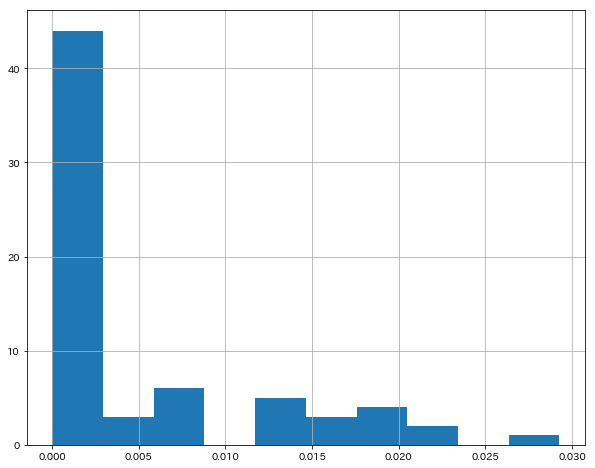

In [25]:
# 標準偏差の値をヒストグラムで描画
std_df['std_tf_idf'].hist(figsize=(10,8))

# グラフより、標準偏差が0.010未満の単語はどの文書にも出現しており特徴がない単語と言える
# 以降、標準偏差が0.010以上の単語のみを特徴量として選択

In [26]:
# 採用する特徴量一覧
adopt_feature_word_df = std_df[ std_df['std_tf_idf'] >= 0.010 ]
adopt_feature_word_df

,original_type,std_tf_idf
33,で_助詞-格助詞-一般,0.029276
10,\_記号-一般,0.023088
22,「_記号-括弧開,0.023088
23,」_記号-括弧閉,0.019835
27,する_動詞-自立,0.019791
26,が_助詞-格助詞-一般,0.018747
45,れる_動詞-接尾,0.018747
15,t_名詞-固有名詞-組織,0.015643
52,単語_名詞-一般,0.015239
56,型_名詞-接尾-一般,0.015142


In [27]:
# 採用しない特徴量一覧
drop_feature_word_df = std_df[ std_df['std_tf_idf'] < 0.010 ]
drop_feature_word_df

,original_type,std_tf_idf
47,リスト_名詞-一般,0.007571
58,文字列_名詞-固有名詞-一般,0.007571
37,など_助詞-副助詞,0.006907
53,原形_名詞-一般,0.006907
63,表示_名詞-サ変接続,0.006907
55,品詞_名詞-一般,0.006907
39,に_助詞-格助詞-一般,0.005131
9,Parse_名詞-固有名詞-一般,0.004341
32,て_助詞-接続助詞,0.004341
12,n_名詞-固有名詞-組織,0.002565


In [28]:
# 採用、採用しない、それぞれの単語の数を確認
print(len(adopt_feature_word_df))
print(len(drop_feature_word_df))

15
53


## テキスト内容×単語のデータフレーム 作成準備
#### 特徴量の値を「TFIDF値」にする場合、「文書内の出現回数」にする場合を想定して各単語のTFIDF値と出現回数を紐付けたデータフレームを作成しておく

In [29]:
# 採用した単語一覧のデータフレームに[original_type]をキーにして[内容]と[count]、[tf_idf]を紐付ける
# adopt_feature_word_dfは['original_type']カラムのみ必要だがdopt_feature_word_df[original_type']とするとSeries型になるためマージできないので注意
adopt_word_tfidf_merge_df = pd.merge(
    adopt_feature_word_df[['original_type']], idf_merge_df[['内容', 'original_type', 'count', 'tf_idf']], on='original_type', how='inner'
)
adopt_word_tfidf_merge_df

,original_type,内容,count,tf_idf
0,で_助詞-格助詞-一般,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,2,0.099052
1,で_助詞-格助詞-一般,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,2,0.085845
2,で_助詞-格助詞-一般,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,1,0.031407
3,\_記号-一般,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,1,0.056438
4,\_記号-一般,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,2,0.102615
5,「_記号-括弧開,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,1,0.056438
6,「_記号-括弧開,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,2,0.102615
7,」_記号-括弧閉,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,1,0.042923
8,」_記号-括弧閉,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,2,0.078041
9,」_記号-括弧閉,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,1,0.031407


## テキスト内容×単語のデータフレーム を作成(TFIDF値採用)

In [30]:
document_word_tfidf_df = adopt_word_tfidf_merge_df[['内容', 'original_type', 'tf_idf']]
document_word_tfidf_df

,内容,original_type,tf_idf
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,で_助詞-格助詞-一般,0.099052
1,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,で_助詞-格助詞-一般,0.085845
2,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,で_助詞-格助詞-一般,0.031407
3,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,\_記号-一般,0.056438
4,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,\_記号-一般,0.102615
5,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,「_記号-括弧開,0.056438
6,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,「_記号-括弧開,0.102615
7,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,」_記号-括弧閉,0.042923
8,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,」_記号-括弧閉,0.078041
9,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,」_記号-括弧閉,0.031407


In [31]:
model_tfidf_df = pd.pivot_table(document_word_tfidf_df, index='内容', columns='original_type', values='tf_idf')
# nanは0に変換する
model_tfidf_df = model_tfidf_df.fillna(0)
model_tfidf_df

original_type,\_記号-一般,__記号-一般,t_名詞-固有名詞-組織,text_名詞-固有名詞-一般,、_記号-読点,「_記号-括弧開,」_記号-括弧閉,が_助詞-格助詞-一般,する_動詞-自立,で_助詞-格助詞-一般,の_助詞-連体化,は_助詞-係助詞,れる_動詞-接尾,単語_名詞-一般,型_名詞-接尾-一般
内容,,,,,,,,,,,,,,,
neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して表示される,0.000000,0.065121,0.000000,0.065121,0.038462,0.000000,0.000000,0.065121,0.076923,0.099052,0.038462,0.000000,0.065121,0.049526,0.000000
まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、リスト型にする,0.056438,0.000000,0.000000,0.000000,0.033333,0.056438,0.042923,0.000000,0.066667,0.085845,0.033333,0.042923,0.000000,0.042923,0.112876
原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,0.102615,0.000000,0.051307,0.000000,0.060606,0.102615,0.078041,0.102615,0.060606,0.000000,0.060606,0.078041,0.102615,0.078041,0.000000
次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid_textは文字列型ではなくリスト型のためsplit関数を使用できない,0.000000,0.041296,0.082593,0.041296,0.024390,0.000000,0.031407,0.000000,0.024390,0.031407,0.024390,0.062814,0.000000,0.000000,0.082593


In [32]:
model_tfidf_df.shape

(4, 15)

In [34]:
#　Mac環境でもencoding='utf-8'を設定して出力する
model_tfidf_df.to_csv('model_tfidf_df.csv', encoding='utf-8')

Mac環境の場合、csvファイルを出力した後

一旦CSVファイルを右クリックし、「このアプリケーションで開く」→「テキストエディット」を選択

command + shift + S をタップし、ファイルを複製

command + S をタップし保存画面を開く

「名前」を、任意の名前に「.csv」を付けた名前にして、「標準テキストのエンコーディング」を「日本語（Shift JIS）」として、保存

参考URL：https://support.freee.co.jp/hc/ja/articles/115002727126-CSV%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%8C%E6%96%87%E5%AD%97%E5%8C%96%E3%81%91%E3%81%97%E3%81%9F%E5%A0%B4%E5%90%88%E3%81%AE%E5%AF%BE%E5%87%A6%E6%96%B9%E6%B3%95#mac

### 保存したテキスト内容×単語のデータフレーム を読み込み

In [35]:
# 今回はencoding='utf-8'でjupyter上では文字化けなく読み込めた
#model_tfidf_df = pd.read_csv('model_df.csv', encoding='shift_jis')
model_tfidf_df = pd.read_csv('model_tfidf_df.csv', encoding='utf-8')
model_tfidf_df

,内容,\_記号-一般,__記号-一般,t_名詞-固有名詞-組織,text_名詞-固有名詞-一般,、_記号-読点,「_記号-括弧開,」_記号-括弧閉,が_助詞-格助詞-一般,する_動詞-自立,で_助詞-格助詞-一般,の_助詞-連体化,は_助詞-係助詞,れる_動詞-接尾,単語_名詞-一般,型_名詞-接尾-一般
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,0.000000,0.065121,0.000000,0.065121,0.038462,0.000000,0.000000,0.065121,0.076923,0.099052,0.038462,0.000000,0.065121,0.049526,0.000000
1,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,0.056438,0.000000,0.000000,0.000000,0.033333,0.056438,0.042923,0.000000,0.066667,0.085845,0.033333,0.042923,0.000000,0.042923,0.112876
2,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,0.102615,0.000000,0.051307,0.000000,0.060606,0.102615,0.078041,0.102615,0.060606,0.000000,0.060606,0.078041,0.102615,0.078041,0.000000
3,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,0.000000,0.041296,0.082593,0.041296,0.024390,0.000000,0.031407,0.000000,0.024390,0.031407,0.024390,0.062814,0.000000,0.000000,0.082593


In [36]:
model_tfidf_df.columns

Index(['内容', '\_記号-一般', '__記号-一般', 't_名詞-固有名詞-組織', 'text_名詞-固有名詞-一般',
       '、_記号-読点', '「_記号-括弧開', '」_記号-括弧閉', 'が_助詞-格助詞-一般', 'する_動詞-自立',
       'で_助詞-格助詞-一般', 'の_助詞-連体化', 'は_助詞-係助詞', 'れる_動詞-接尾', '単語_名詞-一般',
       '型_名詞-接尾-一般'],
      dtype='object')

## テキスト内容×単語のデータフレーム を作成(文書内単語出現回数採用)

In [37]:
document_word_bow_df = adopt_word_tfidf_merge_df[['内容', 'original_type', 'count']]
document_word_bow_df

,内容,original_type,count
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,で_助詞-格助詞-一般,2
1,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,で_助詞-格助詞-一般,2
2,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,で_助詞-格助詞-一般,1
3,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,\_記号-一般,1
4,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,\_記号-一般,2
5,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,「_記号-括弧開,1
6,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,「_記号-括弧開,2
7,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,」_記号-括弧閉,1
8,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,」_記号-括弧閉,2
9,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,」_記号-括弧閉,1


In [38]:
model_bow_df = pd.pivot_table(document_word_bow_df, index='内容', columns='original_type', values='count')
# nanは0に変換する
model_bow_df = model_bow_df.fillna(0)
model_bow_df

original_type,\_記号-一般,__記号-一般,t_名詞-固有名詞-組織,text_名詞-固有名詞-一般,、_記号-読点,「_記号-括弧開,」_記号-括弧閉,が_助詞-格助詞-一般,する_動詞-自立,で_助詞-格助詞-一般,の_助詞-連体化,は_助詞-係助詞,れる_動詞-接尾,単語_名詞-一般,型_名詞-接尾-一般
内容,,,,,,,,,,,,,,,
neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して表示される,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0,0.0
まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、リスト型にする,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0
原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,2.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0
次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid_textは文字列型ではなくリスト型のためsplit関数を使用できない,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0


In [39]:
model_bow_df.shape

(4, 15)

In [40]:
#　Mac環境でもencoding='utf-8'を設定して出力する
model_bow_df.to_csv('model_bow_df.csv', encoding='utf-8')

### 保存したテキスト内容×単語のデータフレーム を読み込み

In [41]:
model_bow_df = pd.read_csv('model_bow_df.csv', encoding='utf-8')
model_bow_df

,内容,\_記号-一般,__記号-一般,t_名詞-固有名詞-組織,text_名詞-固有名詞-一般,、_記号-読点,「_記号-括弧開,」_記号-括弧閉,が_助詞-格助詞-一般,する_動詞-自立,で_助詞-格助詞-一般,の_助詞-連体化,は_助詞-係助詞,れる_動詞-接尾,単語_名詞-一般,型_名詞-接尾-一般
0,neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0,0.0
1,まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0
2,原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される,2.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0
3,次に邪魔な文字「\t」を省きたい。よって、split('\t')を使用したいがwakatid...,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0


In [42]:
model_bow_df.columns

Index(['内容', '\_記号-一般', '__記号-一般', 't_名詞-固有名詞-組織', 'text_名詞-固有名詞-一般',
       '、_記号-読点', '「_記号-括弧開', '」_記号-括弧閉', 'が_助詞-格助詞-一般', 'する_動詞-自立',
       'で_助詞-格助詞-一般', 'の_助詞-連体化', 'は_助詞-係助詞', 'れる_動詞-接尾', '単語_名詞-一般',
       '型_名詞-接尾-一般'],
      dtype='object')